# Tutorial: Example-Dependent Clasification for Credit Scoring

## Prerequisites

For running this tutorial you need:
-    Python version $\ge$ 2.7
-    Numpy version $\ge$ 1.8.0
-    Pandas version $\ge$ 0.14.0
-    Scikit-learn version $\ge$ 0.15.0b2
-    pyea version $\ge$ 0.1
-    CostCla version $\ge$ 0.4dev2

The easiest way to install CostCla  is with pip:
```
pip install costcla
```

see https://github.com/albahnsen/CostSensitiveClassification

  ## Credit Scoring
  
  In order to mitigate the impact of credit risk and make more objective and accurate decisions, 
  financial institutions use credit scores to predict and control their losses.
  The objective in credit scoring is to classify which potential customers are likely to default a 
  contracted financial obligation based on the customer's past financial experience, and with that 
  information decide whether to approve or decline a loan [1]. This tool has 
  become a standard practice among financial institutions around the world in order to predict 
  and control their loans portfolios. When constructing credit scores, it is a common practice to 
  use standard cost-insensitive binary classification algorithms such as logistic regression, 
  neural networks, discriminant analysis, genetic programing, decision trees, among 
  others [2,3]. 
  
  Formally, a credit score is a statistical model that allows the estimation of the probability 
  $\hat p_i=P(y_i=1|\mathbf{x}_i)$ of a customer $i$ defaulting a contracted debt. Additionally, 
since the objective of credit scoring is to estimate a classifier $c_i$ to decide whether or not to grant a 
loan to a customer $i$, a threshold $t$ is defined such that if $\hat p_i < t $, then the loan is 
  granted, i.e., $c_i(t)=0$, and denied otherwise, i.e., $c_i(t)=1$.

## Example: Kaggle Credit Competition

Credit Risk Assessment on a Private Label Credit Card Application

### Load dataset and show basic statistics

In [1]:
import pandas as pd
import numpy as np
from costcla.datasets import load_creditscoring1
data = load_creditscoring1()

# Elements of the data file
print data.keys()

['target_names', 'cost_mat', 'name', 'DESCR', 'feature_names', 'data', 'target']


In [2]:
# Full description of the dataset
# print data.DESCR

In [3]:
# Number of features
print data.feature_names
print data.data.shape

['RevolvingUtilizationOfUnsecuredLines' 'age'
 'NumberOfTime30-59DaysPastDueNotWorse' 'DebtRatio' 'MonthlyIncome'
 'NumberOfOpenCreditLinesAndLoans' 'NumberOfTimes90DaysLate'
 'NumberRealEstateLoansOrLines' 'NumberOfTime60-89DaysPastDueNotWorse'
 'NumberOfDependents']
(112915, 10)


In [4]:
# Percentage of bad (positive) clients
print data.target.mean()*100

6.74489660364


### Credit scoring as a standard classification problem

Using three classifiers, a model is learned to classify customers in good and bad

In [5]:
# Load classifiers and split dataset in training and testing
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test, cost_mat_train, cost_mat_test = \
train_test_split(data.data, data.target, data.cost_mat)

# Fit the classifiers using the training dataset
classifiers = {"RF": {"f": RandomForestClassifier()},
               "DT": {"f": DecisionTreeClassifier()},
               "LR": {"f": LogisticRegression()}}

for model in classifiers.keys():
    # Fit
    classifiers[model]["f"].fit(X_train, y_train)
    # Predict
    classifiers[model]["c"] = classifiers[model]["f"].predict(X_test)
    classifiers[model]["p"] = classifiers[model]["f"].predict_proba(X_test)
    classifiers[model]["p_train"] = classifiers[model]["f"].predict_proba(X_train)

  After the classifier $c_i$ is estimated, there is a need to evaluate its performance. In 
  practice, many statistical evaluation measures are used to assess the performance of a credit 
  scoring model. Measures such as the area under the  receiver operating characteristic curve (AUC),
  Brier score, Kolmogorov-Smirnoff (K-S) statistic,  $F_1$-Score, and misclassification are among 
  the most common [4]. 

In [6]:
# Evaluate the performance
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
measures = {"f1": f1_score, "pre": precision_score, 
            "rec": recall_score, "acc": accuracy_score}
results = pd.DataFrame(columns=measures.keys())

# Evaluate each model in classifiers
for model in classifiers.keys():
    results.loc[model] = [measures[measure](y_test, classifiers[model]["c"]) for measure in measures.keys()]

print results

         pre        f1       acc       rec
RF  0.482258  0.237773  0.932091  0.157784
LR  0.510204  0.073457  0.932977  0.039578
DT  0.244809  0.255673  0.895427  0.267546


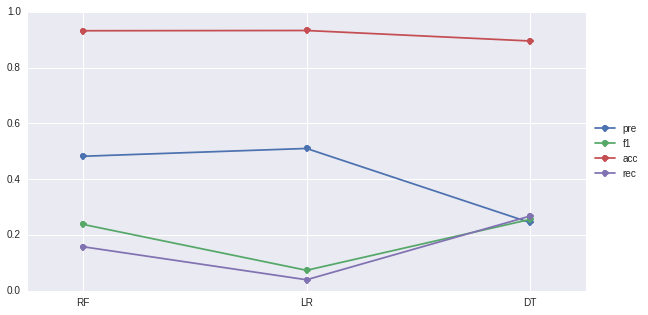

In [7]:
# Plot the results
%matplotlib inline
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt
import seaborn as sns

figsize(10, 5)
ax = plt.subplot(111)

ind = np.arange(results.shape[0])
width = 0.2
l = ax.plot(ind, results, "-o")
plt.legend(iter(l), results.columns.tolist(), loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlim([-0.25, ind[-1]+.25])
ax.set_xticks(ind)
ax.set_xticklabels(results.index)
plt.show()

  Nevertheless, none of these measures takes into account the 
  business and economical realities that take place in credit scoring. Costs that the financial 
  institution had incurred to acquire customers, or the expected profit due to a particular client, 
  are not considered in the evaluation of the different models. 

### Financial Evaluation of a Credit Scorecard

  Typically, a credit risk model is evaluated using standard cost-insensitive measures.
  However, in practice, the cost associated with approving 
  what is known as a bad customer, i.e., a customer who default his credit loan, is quite 
  different from the cost associated with declining a good customer,  i.e., a customer who 
  successfully repay his credit loan. Furthermore, the costs are not constant among customers. 
  This is because loans have different credit line amounts, terms, and even interest rates. Some 
  authors have proposed methods that include the misclassification costs in the credit scoring 
  context [4,5,6,7].
  
  In order to take into account the varying costs that each example carries, we proposed in 
  [8], a cost matrix with example-dependent misclassification costs as 
  given in the following table.
  
  
|  	| Actual Positive ($y_i=1$)  	|  Actual Negative 	($y_i=0$)|
|---	|:-:	|:-:	|
|   Predicted Positive ($c_i=1$)	|   $C_{TP_i}=0$	|  $C_{FP_i}=r_i+C^a_{FP}$ 	|
|  Predicted Negative  ($c_i=0$) 	|   $C_{FN_i}=Cl_i \cdot L_{gd}$	| $C_{TN_i}=0$	|
  
  First, we assume that the costs of a correct 
  classification, $C_{TP_i}$ and $C_{TN_i}$, are zero for every customer $i$. We define $C_{FN_i}$ 
  to be the losses if the customer $i$ defaults to be proportional to his credit line $Cl_i$. We 
  define the cost of a false positive per customer $C_{FP_i}$ as the sum of two real financial 
  costs $r_i$ and $C^a_{FP}$, where $r_i$ is the loss in profit by rejecting what would have been a 
  good customer. 
  
  The profit per customer $r_i$ is calculated as the present value of the difference between the 
  financial institution gains and expenses, given the credit line $Cl_i$, the term $l_i$ and the 
  financial institution lending rate $int_{r_i}$ for customer $i$, and the financial institution 
  of cost funds $int_{cf}$.

  $$  r_i= PV(A(Cl_i,int_{r_i},l_i),int_{cf},l_i)-Cl_i,$$
  
  with $A$ being the customer monthly payment and $PV$ the present value of the monthly payments,
  which are calculated using the time value of money equations [9],
 
 $$ A(Cl_i,int_{r_i},l_i) =  Cl_i \frac{int_{r_i}(1+int_{r_i})^{l_i}}{(1+int_{r_i})^{l_i}-1},$$
 
 $$ PV(A,int_{cf},l_i) = \frac{A}{int_{cf}} \left(1-\frac{1}{(1+int_{cf})^{l_i}} \right).$$
      
  The second term $C^a_{FP}$, is related to the assumption that the financial institution will not 
  keep the money of the declined customer idle. It will instead give a loan to an alternative 
  customer [10]. Since no further information is known about the alternative customer, 
  it is assumed to have an average credit line $\overline{Cl}$ and an average profit $\overline{r}$.
  Given that, 
  
  $$  C^a_{FP}=- \overline{r} \cdot \pi_0+\overline{Cl}\cdot L_{gd} \cdot \pi_1,$$

  in other words minus the profit of an average alternative customer plus the expected loss, 
  taking into account that the alternative customer will pay his debt with a probability equal to 
  the prior negative rate, and similarly will default with probability equal to the prior positive 
  rate.
  
  One key parameter of our model is the credit limit. There exists several strategies to calculate 
  the $Cl_i$ depending on the type of loans, the state of the economy, the current portfolio, 
  among others [1,9]. Nevertheless, given the lack of information 
  regarding the specific business environments of the considered datasets, we simply define 
  $Cl_i$ as

$$      Cl_i = \min \bigg\{ q \cdot Inc_i, Cl_{max}, Cl_{max}(debt_i) \bigg\},$$
  
  where $Inc_i$ and $debt_i$ are the monthly income and debt ratio of the customer $i$, 
  respectively, $q$ is a parameter that defines the maximum $Cl_i$ in times $Inc_i$, and 
  $Cl_{max}$ the maximum overall credit line. Lastly, the maximum credit line given the current 
  debt is calculated as the maximum credit limit such that the current debt ratio plus the new 
  monthly payment does not surpass the customer monthly income. It is calculated as
 
 $$  Cl_{max}(debt_i)=PV\left(Inc_i \cdot P_{m}(debt_i),int_{r_i},l_i\right),$$
  and
  $$ P_{m}(debt_i)=\min \left\{ \frac{A(q \cdot Inc_i,int_{r_i},l_i)}{Inc_i},\left(1-debt_i \right) \right\}.$$
  
  
### Financial savings

  Let $\mathcal{S}$ be a set of $N$ examples $i$, $N=\vert S \vert$, where each example is 
  represented by  the augmented feature vector 
  $\mathbf{x}_i^*=[\mathbf{x}_i, C_{TP_i},C_{FP_i},C_{FN_i},C_{TN_i}]$  
  and labeled using the class   label $y_i   \in \{0,1\}$. 
  A classifier $f$ which generates the   predicted label $c_i$ for each   element $i$ is trained  
  using the set $\mathcal{S}$. Then the cost of   using $f$ on $\mathcal{S}$ is calculated by
  
  $$   Cost(f(\mathcal{S})) = \sum_{i=1}^N Cost(f(\mathbf{x}_i^*)),$$
  
  where
  
 $$   Cost(f(\mathbf{x}_i^*)) = y_i(c_i C_{TP_i} + (1-c_i)C_{FN_i}) + (1-y_i)(c_i C_{FP_i} + (1-c_i)C_{TN_i}).$$
  

  However, the total cost may not be easy to interpret. We proposed an approach in [8], where the savings of using an algorithm  are defined as the cost of the algorithm versus the cost of using no algorithm at all.  To do that, the cost of the costless class is defined as 
  
  $$  Cost_l(\mathcal{S}) = \min \{Cost(f_0(\mathcal{S})), Cost(f_1(\mathcal{S}))\},$$
  
  where 
  
  $$  f_a(\mathcal{S}) = \mathbf{a}, \text{ with } a\in \{0,1\}.$$
  

  The cost improvement can be expressed as the cost savings as compared with $Cost_l(\mathcal{S})$. 
  
  $$    Savings(f(\mathcal{S})) = \frac{ Cost_l(\mathcal{S}) - Cost(f(\mathcal{S}))}   {Cost_l(\mathcal{S})}.$$
  


  ### Parameters for the Kaggle Credit Database

 As this database contain information regarding the features, and more importantly about the income of each example, from which an estimated credit limit $Cl_i$ can be calculated.
Since no specific information regarding the datasets is provided, we assume that they belong to  an
average Portuguese financial institution. This enabled us to find the different 
parameters needed to calculate the cost measure. 

| Parameter 	| Value |
|---	|:-:	|
|Interest rate ($int_r$) | 4.79% |
|  Cost of funds ($int_{cf}$) | 2.94% |
|  Term ($l$) in months | 24 |
|  Loss given default ($L_{gd}$) | 75% |
|  Times income ($q$) | 3 |
|  Maximum credit line ($Cl_{max}$) | 25,000|

In particular, we obtain the average interest rates in Europe during   2013 from the European Central Bank [11]. Additionally, we use a fixed loan term $l$ to two years,
considering that in the Kaggle Credit dataset the class was constructed to predict two years of credit behavior.
Moreover, we set the loss given default $L_{gd}$ using information from 
the Basel II standard, $q$ to 3 since it is the average personal loan requests related to monthly income, and the maximum credit limit $Cl_{max}$ to 25,000 Euros.

### Calculation of the savings of the models

In [8]:
# The cost matrix is already calculated for the dataset
# cost_mat[C_FP,C_FN,C_TP,C_TN]
print data.cost_mat[[10, 17, 50]]

[[  1023.73054104  18750.              0.              0.        ]
 [   717.25781516   6749.25            0.              0.        ]
 [   866.65393177  12599.25            0.              0.        ]]


In [9]:
# Calculation of the cost and savings
from costcla.metrics import savings_score, cost_loss 

# Evaluate the savings for each model
results["sav"] = np.zeros(results.shape[0])
for model in classifiers.keys():
    results["sav"].loc[model] = savings_score(y_test, classifiers[model]["c"], cost_mat_test)

# TODO: plot results
print results

         pre        f1       acc       rec       sav
RF  0.482258  0.237773  0.932091  0.157784  0.131889
LR  0.510204  0.073457  0.932977  0.039578  0.025837
DT  0.244809  0.255673  0.895427  0.267546  0.199281


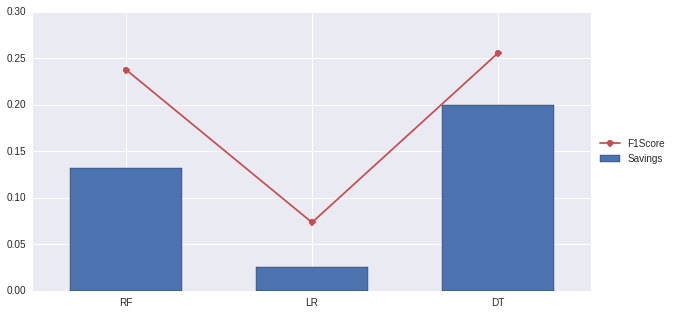

In [10]:
# Plot the results
colors = sns.color_palette()

figsize(10, 5)
ax = plt.subplot(111)
l = ax.plot(ind, results["f1"], "-o", label='F1Score', color=colors[2])
b = ax.bar(ind-0.3, results['sav'], 0.6, label='Savings', color=colors[0])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlim([-0.5, ind[-1]+.5])
ax.set_xticks(ind)
ax.set_xticklabels(results.index)
plt.show()

There are significant differences in the 
results when evaluating a model using a  traditional cost-insensitive measure such as the 
accuracy or F1Score,  than when using the savings, leading to the conclusion of the 
importance of using the real practical financial costs of each context.

### Bayes minimum risk

As these methods (RF, LR and DT) are not performing well we then move to use cost-sensitive methods. The first model we used is the Bayes minimum risk model (BMR) [8].
As defined in [12], the BMR classifier is a decision model based on quantifying 
tradeoffs between various decisions using probabilities and the costs that accompany such decisions. 
This is done in a way that for each example the expected losses are minimized. In  what follows, we 
consider the probability estimates $\hat p_i$ as known, regardless of the algorithm used to 
calculate them.  The risk that accompanies each decision is calculated using the cost matrix described above.
In the specific framework of binary classification, the risk of predicting the example $i$ as negative is 

$$ R(c_i=0|\mathbf{x}_i)=C_{TN_i}(1-\hat p_i)+C_{FN_i} \cdot \hat p_i, $$
and
$$ R(c_i=1|\mathbf{x}_i)=C_{TP_i} \cdot \hat p_i + C_{FP_i}(1- \hat p_i), $$

is the risk when predicting the example as positive, where $\hat p_i$ is the estimated positive 
probability for example $i$. Subsequently, if 

$$  R(c_i=0|\mathbf{x}_i) \le R(c_i=1|\mathbf{x}_i), $$

then  the example $i$ is classified as negative. This means that the risk associated with the 
decision $c_i$ is lower than the risk associated with classifying it as positive. 


In [11]:
from costcla.models import BayesMinimumRiskClassifier
ci_models = classifiers.keys()

for model in ci_models:
    classifiers[model+"-BMR"] = {"f": BayesMinimumRiskClassifier()}
    # Fit
    classifiers[model+"-BMR"]["f"].fit(y_test, classifiers[model]["p"])
    # Predict
    classifiers[model+"-BMR"]["c"] = classifiers[model+"-BMR"]["f"].predict(classifiers[model]["p"], cost_mat_test)
    # Evaluate
    results.loc[model+"-BMR"] = 0
    results.loc[model+"-BMR", measures.keys()] = \
    [measures[measure](y_test, classifiers[model+"-BMR"]["c"]) for measure in measures.keys()]
    results["sav"].loc[model+"-BMR"] = savings_score(y_test, classifiers[model+"-BMR"]["c"], cost_mat_test)
    
print results 

             pre        f1       acc       rec       sav
RF      0.482258  0.237773  0.932091  0.157784  0.131889
LR      0.510204  0.073457  0.932977  0.039578  0.025837
DT      0.244809  0.255673  0.895427  0.267546  0.199281
RF-BMR  0.174189  0.274903  0.769209  0.651715  0.425935
LR-BMR  0.150748  0.229882  0.782351  0.483905  0.284600
DT-BMR  0.082378  0.137800  0.646250  0.421108  0.102496


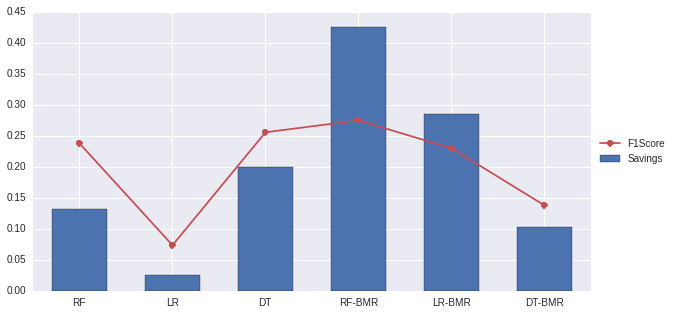

In [12]:
# Plot the results
ind = np.arange(results.shape[0])
figsize(10, 5)
ax = plt.subplot(111)
l = ax.plot(ind, results["f1"], "-o", label='F1Score', color=colors[2])
b = ax.bar(ind-0.3, results['sav'], 0.6, label='Savings', color=colors[0])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlim([-0.5, ind[-1]+.5])
ax.set_xticks(ind)
ax.set_xticklabels(results.index)
plt.show()

### Cost-sensitive decision trees

The next algorithm that is evaluated is the cost-sensitive decision trees algorithm [13].

Decision trees are one of the most widely used machine learning algorithms [14]. 
The technique is considered to be white box, in the sense that is easy to interpret, and has a 
very low computational cost, while maintaining a good performance as compared with more complex 
techniques [15]. There are two types of decision tree depending on the objective of 
the model. They work either for classification or regression. 

- Construction of classification trees

Classification trees is one of the most common types of decision tree, in which the objective 
is to find the $Tree$ that best discriminates between classes. In general the decision tree 
represents a set of splitting rules organized in levels in a flowchart structure.

- Splitting criteria

In the $Tree$, each rule is shown as a node, and it is represented as $(\mathbf{x}^j,l^j)$, meaning 
that the set $\mathcal{S}$ is split in two sets $\mathcal{S}^l$ and $\mathcal{S}^r$ according to 
$\mathbf{x}^j$ and $l^j$:

$$ \mathcal{S}^l = \{\mathbf{x}_i^* \vert \mathbf{x}_i^* \in \mathcal{S} \wedge x^j_i \le l^j \}, \quad and \quad
  \mathcal{S}^r = \{\mathbf{x}_i^* \vert \mathbf{x}_i^* \in \mathcal{S} \wedge x^j_i > l^j \}, $$

where $\mathbf{x}^j$ is the $j^{th}$ feature represented in the vector 
$\mathbf{x}^j=[x_1^j,x_2^j,...,x_N^j]$, and $l^j$ is a value such that $min(\mathbf{x}^j) \le l^j < 
max(\mathbf{x}^j)$. Moreover, $\mathcal{S} = \mathcal{S}^l \cup \mathcal{S}^r$.

After the training set have been split, the percentage of positives in the different sets is calculated. First, the number of positives in each set is estimated by

$$ \mathcal{S}_1 = \{\mathbf{x}_i^* \vert \mathbf{x}_i^* \in \mathcal{S} \wedge y_i =1 \}, $$

and the percentage of positives is calculates as $\pi_1=\vert \mathcal{S}_1 \vert / \vert \mathcal{S} \vert.$

Then, the impurity of each leaf is calculated using either a misclassification error, 
entropy or Gini measures:


a) Misclassification: 
    $I_m(\pi_1)=1-max(\pi_1,1-\pi_1)$ 

b) Entropy: $I_e(\pi_1)=-\pi_1\log \pi_1 -(1-\pi_1) \log (1-\pi_1)$ 

c) Gini: 
    $I_g(\pi_1)=2\pi_1(1-\pi_1)$

Finally the gain of the splitting criteria using the rule $(\mathbf{x}^j,l^j)$ is calculated as the 
impurity of $\mathcal{S}$ minus the weighted impurity of each leaf:

$$  Gain(\mathbf{x}^j,l^j)=I(\pi_1)-\frac{\vert \mathcal{S}^l \vert}{\vert \mathcal{S} 
\vert}I(\pi^l_1)  -\frac{\vert \mathcal{S}^r \vert}{\vert \mathcal{S} \vert}I(\pi^r_1), $$

where $I(\pi_1)$ can be either of the impurity measures $I_e(\pi_1)$ or $I_g(\pi_1)$.

Subsequently, the gain of all possible splitting rules is calculated. The rule with maximal 
gain is selected

$$  (best_x, best_l) = argmax_{(\mathbf{x}^j,l^j)}Gain(\mathbf{x}^j,l^j), $$

and the set $\mathcal{S}$ is split into $\mathcal{S}^l$ and $\mathcal{S}^r$ according to that rule. 


- Tree growing

In order to grow a tree typical algorithms use a top-down induction using a greedy search in each
iteration [16]. In each iteration, the algorithms evaluates all possible splitting 
rules and pick the one that maximizes the splitting criteria. After the selection of a splitting 
rule, each leaf is further selected and it is subdivides into smaller leafs, until one of the 
stopping criteria is meet. 

- Cost-sensitive impurity measures

Standard impurity measures such as misclassification, entropy or Gini, take into account the 
distribution of classes of each leaf to evaluate the predictive power of a splitting rule,
leading to an impurity measure that is based on minimizing the misclassification rate. However, 
as has been previously shown [8], minimizing misclassification does not 
lead to the same results than minimizing cost. Instead, we are interested in measuring how good 
is a splitting rule in terms of cost not only accuracy. For doing that, we propose a new 
example-dependent cost based impurity measure that takes into account the cost matrix of each 
example.

We define a new cost-based impurity measure taking into account the costs when all the examples
in a leaf are classified both as negative using $f_0$ and positive using $f_1$

$$    I_c(\mathcal{S}) = \min \bigg\{ Cost(f_0(\mathcal{S})), Cost(f_1(\mathcal{S})) \bigg\}. $$

The objective of this measure is to evaluate the lowest expected cost of a splitting rule.
Following the same logic, the classification of each set is calculated as the prediction that 
leads to the lowest cost

$$
f(\mathcal{S}) = 
\begin{cases}
  \phantom{-}0 \phantom{-} \mbox{if} \phantom{-} Cost(f_0(\mathcal{S})) \le 
Cost(f_1(\mathcal{S}))\\
  \phantom{-}1 \phantom{-}\mbox{otherwise}
\end{cases}
$$

Finally, using the cost-based impurity, the splitting criteria cost based gain of using the 
splitting rule $(\mathbf{x}^j,l^j)$ is calculated. 

In [13]:
from costcla.models import CostSensitiveDecisionTreeClassifier

classifiers["CSDT"] = {"f": CostSensitiveDecisionTreeClassifier()}
# Fit
classifiers["CSDT"]["f"].fit(X_train, y_train, cost_mat_train)
# Predict
classifiers["CSDT"]["c"] = classifiers["CSDT"]["f"].predict(X_test)
# Evaluate
results.loc["CSDT"] = 0
results.loc["CSDT", measures.keys()] = \
[measures[measure](y_test, classifiers["CSDT"]["c"]) for measure in measures.keys()]
results["sav"].loc["CSDT"] = savings_score(y_test, classifiers["CSDT"]["c"], cost_mat_test)
    
print results

             pre        f1       acc       rec       sav
RF      0.482258  0.237773  0.932091  0.157784  0.131889
LR      0.510204  0.073457  0.932977  0.039578  0.025837
DT      0.244809  0.255673  0.895427  0.267546  0.199281
RF-BMR  0.174189  0.274903  0.769209  0.651715  0.425935
LR-BMR  0.150748  0.229882  0.782351  0.483905  0.284600
DT-BMR  0.082378  0.137800  0.646250  0.421108  0.102496
CSDT    0.172303  0.283272  0.729675  0.795778  0.487350


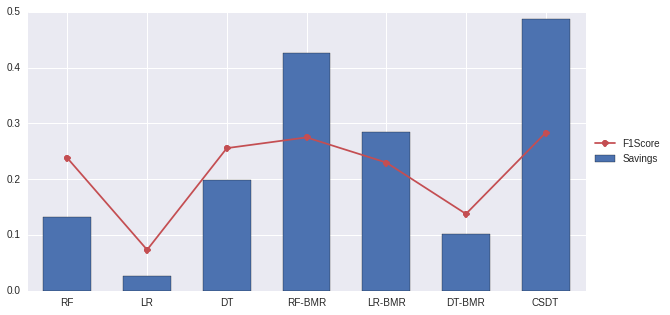

In [14]:
# Plot the results
ind = np.arange(results.shape[0])
figsize(10, 5)
ax = plt.subplot(111)
l = ax.plot(ind, results["f1"], "-o", label='F1Score', color=colors[2])
b = ax.bar(ind-0.3, results['sav'], 0.6, label='Savings', color=colors[0])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlim([-0.5, ind[-1]+.5])
ax.set_xticks(ind)
ax.set_xticklabels(results.index)
plt.show()

### Cost-Sensitive Random Patches

Ensemble learning is a widely studied topic in the machine learning community. The main idea behind the ensemble methodology is to combine several individual base classifiers in   order to have a 
classifier that outperforms each of them [17]. Nowadays,   ensemble methods are  one of the most popular and well studied machine learning techniques [18], and it can be noted that since 2009 all the first-place and   second-place winners of the KDD-Cup (https://www.sigkdd.org/kddcup/)   used  ensemble methods. The core 
principle in ensemble learning, is to induce random perturbations into  the learning procedure in order to produce several different base classifiers from a single  training set, then combining the 
base classifiers in order to make the final prediction.  In order to induce the random permutations and therefore create the different base classifiers,   several methods have been proposed, in 
particular: bagging,   pasting, random forests and random patches [19]. Finally, after  the base   classifiers are trained, they are typically   combined using either   majority voting,  weighted  voting    or  stacking [18].

With the objective of creating an ensemble of example-dependent cost-sensitive decision trees, we first create $T$ different random subsamples $\mathcal{S}_j$ for $j=1,\dots,T$, of the training  set 
$\mathcal{S}$, and train a $CSDT$ algorithm on each one. In particular we create the different [19]. In the random patches algorithm, base classifiers are created by randomly  drawn bootstrap subsets of both examples and features. 

Lastly, after the base classifiers are trained, we combine them using cost-sensitive weighted voting. This method is based in based in calculating the final prediction as a weighted average of the base classifiers estimation:

$$  f_{wv}(\mathcal{S},\mathcal{M}, \alpha)
  =argmax_{c \in \{0,1\}} \sum_{j=1}^T \alpha_j \mathbf{1}_c(M_j(\mathcal{S})), $$
  
where  $\alpha_j$ is related to the performance of each classifier $M_j$ in the  out of bag set   $\mathcal{S}_j^{oob}=\mathcal{S}-\mathcal{S}_j$

$$  \alpha_j=\frac{Savings(M_j(\mathcal{S}_j^{oob}))}
  {\sum_{j_1=1}^T Savings(M_{j_1}(\mathcal{S}_j^{oob}))}. $$

This method guaranties that the base classifiers that contribute to a higher increase in savings 
have more importance in the ensemble. For more details see [20].

In [23]:
from costcla.models import CostSensitiveRandomPatchesClassifier

classifiers["CSRP"] = {"f": CostSensitiveRandomPatchesClassifier(combination='weighted_voting')}
# Fit
classifiers["CSRP"]["f"].fit(X_train, y_train, cost_mat_train)
# Predict
classifiers["CSRP"]["c"] = classifiers["CSRP"]["f"].predict(X_test)
# Evaluate
results.loc["CSRP"] = 0
results.loc["CSRP", measures.keys()] = \
[measures[measure](y_test, classifiers["CSRP"]["c"]) for measure in measures.keys()]
results["sav"].loc["CSRP"] = savings_score(y_test, classifiers["CSRP"]["c"], cost_mat_test)
    
print results

             pre        f1       acc       rec       sav
RF      0.482258  0.237773  0.932091  0.157784  0.131889
LR      0.510204  0.073457  0.932977  0.039578  0.025837
DT      0.244809  0.255673  0.895427  0.267546  0.199281
RF-BMR  0.174189  0.274903  0.769209  0.651715  0.425935
LR-BMR  0.150748  0.229882  0.782351  0.483905  0.284600
DT-BMR  0.082378  0.137800  0.646250  0.421108  0.102496
CSDT    0.172303  0.283272  0.729675  0.795778  0.487350
CSRP    0.267432  0.379242  0.856778  0.651715  0.495989


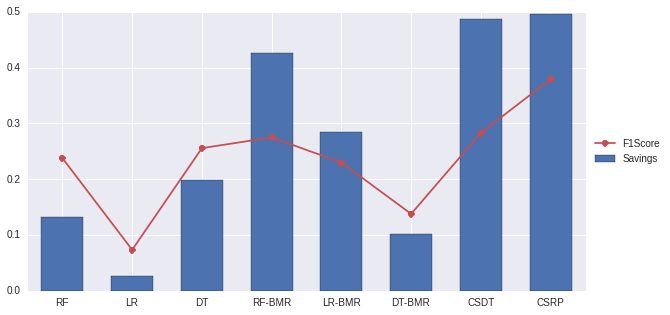

In [24]:
# Plot the results
ind = np.arange(results.shape[0])
figsize(10, 5)
ax = plt.subplot(111)
l = ax.plot(ind, results["f1"], "-o", label='F1Score', color=colors[2])
b = ax.bar(ind-0.3, results['sav'], 0.6, label='Savings', color=colors[0])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlim([-0.5, ind[-1]+.5])
ax.set_xticks(ind)
ax.set_xticklabels(results.index)
plt.show()

### Conclusions

CostCla is a easy to use Python library for example-dependent cost-sensitive 
classification problems. It includes many example-dependent cost-sensitive algorithms. Since 
it is part of the scientific Python ecosystem, it can be easily integrated with other 
machine learning libraries. Future work includes adding more cost-sensitive databases and 
algorithms, and support for Python $\ge$ 3.4. 

## References
1. Anderson, R. (2007). The Credit Scoring Toolkit : Theory and Practice for Retail Credit Risk Management and Decision Automation. Oxford University Press.
2. Hand, D. J., & Henley, W. E. (1997). Statistical Classification Methods in Consumer Credit Scoring: A Review. Journal of the Royal Statstical Society. Series A (Statistics in Society), 160(3), 523–541.
3. Correa Bahnsen, A., & Gonzalez Montoya, A. (2011). Evolutionary Algorithms for Selecting the Architecture of a MLP Neural Network: A Credit Scoring Case. In IEEE 11th International Conference on Data Mining Workshops (pp. 725–732). Ieee. http://doi.org/10.1109/ICDMW.2011.80
4. Beling, P., Covaliu, Z., & Oliver, R. M. (2005). Optimal scoring cutoff policies and efficient frontiers. Journal of the Operational Research Society, 56(9), 1016–1029. http://doi.org/10.1057/palgrave.jors.2602021
5. Verbraken, T., Bravo, C., Weber, R., & Baesens, B. (2014). Development and application of consumer credit scoring models using profit-based classification measures. European Journal of Operational Research, 238(2), 505–513. http://doi.org/10.1016/j.ejor.2014.04.001
6.  Alejo, R., & Garc, V. (2013). Making Accurate Credit Risk Predictions with Cost-Sensitive MLP Neural Networks. In J. Casillas, F. J. Martínez-López, R. Vicari, & F. De la Prieta (Eds.), Advances in Intelligent Systems and Computing (Vol. 220, pp. 1–8). Heidelberg: Springer International Publishing. http://doi.org/10.1007/978-3-319-00569-0
7.  Oliver, R., & Thomas, L. (2009). Optimal score cutoffs and pricing in regulatory capital in retail credit portfolios (No. CRR-09-01). Southampton. Retrieved from http://eprints.soton.ac.uk/71321/
8.  Correa Bahnsen, A., Aouada, D., & Ottersten, B. (2014). Example-Dependent Cost-Sensitive Logistic Regression for Credit Scoring. In 2014 13th International Conference on Machine Learning and Applications (pp. 263–269). Detroit, USA: IEEE. http://doi.org/10.1109/ICMLA.2014.48
9.  Lawrence, D., & Solomon, A. (2012). Managing a Consumer Lending Business. Solomon Lawrence Partners. 
10. Nayak, G. N., & Turvey, C. G. (1997). Credit Risk Assessment and the Opportunity Costs of Loan Misclassification. Canadian Journal of Agricultural Economics, 45(3), 285–299. http://doi.org/10.1111/j.1744-7976.1997.tb00209.x
11. ECB. (2014). European Central Bank. Retrieved from http://www.ecb.europa.eu/stats
12. Jayanta K., G., Mohan, D., & Tapas, S. (2006). Bayesian Inference and Decision Theory. In An Introduction to Bayesian Analysis (Vol. 13, pp. 26–63). Springer New York. http://doi.org/10.1007/978-0-387-35433-0_2
13. Correa Bahnsen, A., Aouada, D., & Ottersten, B. (2015). Example-Dependent Cost-Sensitive Decision Trees. Expert Systems with Applications, in press. http://doi.org/10.1016/j.eswa.2015.04.042
14. Maimon, L. R. O. (2008). Data Mining with Decision Trees: Theory and Applications. World Scientific Publishing Company.
15. Hastie, T., Tibshirani, R., & Friedman, J. (2009). The Elements of Statistical Learning: Data Mining, Inference, and Prediction (2nd ed.). Stanford, CA: Springer.
16. Rokach, L., & Maimon, O. (2010). Decision Trees. In L. Rokach & O. Maimon (Eds.), Data Mining and Knowledge Discovery Handbook (2nd ed., pp. 149–174). Springer US. http://doi.org/10.1007/978-0-387-09823-4_9
17. \citep{Rokach2009}
18. \citep{Zhou2012}
19. \citep{Louppe2012}
20. Correa Bahnsen, A., Aouada, D., & Ottersten, B. (2015). Ensembles of Example-Dependent Cost-Sensitive Decision Trees. http://arxiv.org/abs/1505.04637